# 파이프라인

목표: state 시계열 데이터가 입력됐을 때, 해당 state가 어느 region에 속하는지 출력

0. 전처리(DTW의 경우 그래프의 모양으로 분석. 전처리 필수 아님)
    - 라벨(target): Climate Region
1. Train / Test Split (8:2, stratified)
    - 소수 클래스의 경우 보완 방안 필요해보임
2. Train data DTW distance 계산  
3. Train feature > DTW distance vector
    ex) AL - [AR, AZ, CA, CO, ... , SC] >>>> [1.1, 1.2, 1.3, ... , 4]
4. Test feature > DTW distance 계산 (test - train)
    ex) SD (TEST DATA) - [AR, AZ, CA, CO, ... , SC] (TRAIN DATA) >>> [2.1, 2.2, ... , 3] (len = train set)
5. 분류 모델 학습
    - 위의 vector 값이 feature로 사용됨 (즉, 48개의 feature)
    - Tree: RF, XGB/LightGBM
    - Linear: Logistic Regression
    - SVM ?
6. 평가

In [1]:
import numpy as np
import pandas as pd

In [2]:
# 데이터 불러오기
df = pd.read_excel('electricity_consumption_dataset_rev.xlsx', header = 1)

In [33]:
df.info

<bound method DataFrame.info of             Energy-related CO2 Emissions  Population (in thousands) State  \
Date                                                                        
1990-01-01                    109.600000                   4050.000    AL   
1990-01-01                     50.800000                   2357.000    AR   
1990-01-01                     63.100000                   3684.000    AZ   
1990-01-01                    360.200000                  29960.000    CA   
1990-01-01                     66.500000                   3308.000    CO   
...                                  ...                        ...   ...   
2023-12-01                      5.471134                    647.464    VT   
2023-12-01                     76.012265                   7812.880    WA   
2023-12-01                     88.924140                   5910.955    WI   
2023-12-01                     71.106032                   1770.071    WV   
2023-12-01                     58.010125    

In [3]:
df.columns

Index(['Sr. No.', 'Energy-related CO2 Emissions', 'Population (in thousands)',
       'Year', 'Month', 'State', 'Cooling Degree Days  (CDD) (냉방 에너지 수요)',
       'Palmer Drought Severity Index (장기적 가뭄 심도 지수)',
       'Palmer Z-index (월별 가뭄 지수)', 'Area Percentage Urban Cluster',
       'Area Percentage Water', 'Climate Region',
       'Residential Electricity Consumption ',
       'Commercial Electricity Consumption ',
       'Industrial Electricity Consumption '],
      dtype='object')

In [4]:
df = df[[
    'Energy-related CO2 Emissions', 
    'Population (in thousands)',
    'Year', 
    'Month', 
    'State', 
    'Cooling Degree Days  (CDD) (냉방 에너지 수요)',
    'Palmer Z-index (월별 가뭄 지수)', 
    'Area Percentage Urban Cluster',
    'Climate Region',
    'Residential Electricity Consumption ',
    'Commercial Electricity Consumption ',
    'Industrial Electricity Consumption '
]
]

In [5]:
df

,Energy-related CO2 Emissions,Population (in thousands),Year,Month,State,Cooling Degree Days (CDD) (냉방 에너지 수요),Palmer Z-index (월별 가뭄 지수),Area Percentage Urban Cluster,Climate Region,Residential Electricity Consumption,Commercial Electricity Consumption,Industrial Electricity Consumption
0,109.600000,4050.000,1990,1,AL,21,2.79,0.99,Southeast,2070093.00,820415.00,2099546.00
1,50.800000,2357.000,1990,1,AR,4,1.17,0.71,South,1026320.00,474988.00,782491.00
2,63.100000,3684.000,1990,1,AZ,0,-0.61,0.33,Southwest,1396499.00,1081793.00,809797.00
3,360.200000,29960.000,1990,1,CA,0,-1.72,0.59,West,6168009.00,6011774.00,4454664.00
4,66.500000,3308.000,1990,1,CO,0,-1.68,0.26,Southwest,1046805.00,1158963.00,545387.00
...,...,...,...,...,...,...,...,...,...,...,...,...
19579,5.471134,647.464,2023,12,VT,0,3.34,1.02,Northeast,210133.06,158700.69,110307.49
19580,76.012265,7812.880,2023,12,WA,0,0.37,0.62,Northwest,3991431.70,2660717.60,1712554.80
19581,88.924140,5910.955,2023,12,WI,0,-1.13,0.90,Upper Midwest,1970865.10,1880493.40,1858590.70
19582,71.106032,1770.071,2023,12,WV,0,-0.74,0.90,Ohio Valley,1114769.00,600830.88,1261384.60


In [6]:
# Total column 생성
df['Total Electricity Consumption'] = df['Residential Electricity Consumption '] + df['Commercial Electricity Consumption '] + df['Industrial Electricity Consumption ']

In [7]:
df

,Energy-related CO2 Emissions,Population (in thousands),Year,Month,State,Cooling Degree Days (CDD) (냉방 에너지 수요),Palmer Z-index (월별 가뭄 지수),Area Percentage Urban Cluster,Climate Region,Residential Electricity Consumption,Commercial Electricity Consumption,Industrial Electricity Consumption,Total Electricity Consumption
0,109.600000,4050.000,1990,1,AL,21,2.79,0.99,Southeast,2070093.00,820415.00,2099546.00,4990054.00
1,50.800000,2357.000,1990,1,AR,4,1.17,0.71,South,1026320.00,474988.00,782491.00,2283799.00
2,63.100000,3684.000,1990,1,AZ,0,-0.61,0.33,Southwest,1396499.00,1081793.00,809797.00,3288089.00
3,360.200000,29960.000,1990,1,CA,0,-1.72,0.59,West,6168009.00,6011774.00,4454664.00,16634447.00
4,66.500000,3308.000,1990,1,CO,0,-1.68,0.26,Southwest,1046805.00,1158963.00,545387.00,2751155.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19579,5.471134,647.464,2023,12,VT,0,3.34,1.02,Northeast,210133.06,158700.69,110307.49,479141.24
19580,76.012265,7812.880,2023,12,WA,0,0.37,0.62,Northwest,3991431.70,2660717.60,1712554.80,8364704.10
19581,88.924140,5910.955,2023,12,WI,0,-1.13,0.90,Upper Midwest,1970865.10,1880493.40,1858590.70,5709949.20
19582,71.106032,1770.071,2023,12,WV,0,-0.74,0.90,Ohio Valley,1114769.00,600830.88,1261384.60,2976984.48


In [8]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY = 1))

In [9]:
df = df.set_index('Date')

In [10]:
df

,Energy-related CO2 Emissions,Population (in thousands),Year,Month,State,Cooling Degree Days (CDD) (냉방 에너지 수요),Palmer Z-index (월별 가뭄 지수),Area Percentage Urban Cluster,Climate Region,Residential Electricity Consumption,Commercial Electricity Consumption,Industrial Electricity Consumption,Total Electricity Consumption
Date,,,,,,,,,,,,,
1990-01-01,109.600000,4050.000,1990,1,AL,21,2.79,0.99,Southeast,2070093.00,820415.00,2099546.00,4990054.00
1990-01-01,50.800000,2357.000,1990,1,AR,4,1.17,0.71,South,1026320.00,474988.00,782491.00,2283799.00
1990-01-01,63.100000,3684.000,1990,1,AZ,0,-0.61,0.33,Southwest,1396499.00,1081793.00,809797.00,3288089.00
1990-01-01,360.200000,29960.000,1990,1,CA,0,-1.72,0.59,West,6168009.00,6011774.00,4454664.00,16634447.00
1990-01-01,66.500000,3308.000,1990,1,CO,0,-1.68,0.26,Southwest,1046805.00,1158963.00,545387.00,2751155.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,5.471134,647.464,2023,12,VT,0,3.34,1.02,Northeast,210133.06,158700.69,110307.49,479141.24
2023-12-01,76.012265,7812.880,2023,12,WA,0,0.37,0.62,Northwest,3991431.70,2660717.60,1712554.80,8364704.10
2023-12-01,88.924140,5910.955,2023,12,WI,0,-1.13,0.90,Upper Midwest,1970865.10,1880493.40,1858590.70,5709949.20


In [11]:
df = df.drop(columns=['Year', 'Month', 'Residential Electricity Consumption ',
       'Commercial Electricity Consumption ',
       'Industrial Electricity Consumption '])

In [12]:
df

,Energy-related CO2 Emissions,Population (in thousands),State,Cooling Degree Days (CDD) (냉방 에너지 수요),Palmer Z-index (월별 가뭄 지수),Area Percentage Urban Cluster,Climate Region,Total Electricity Consumption
Date,,,,,,,,
1990-01-01,109.600000,4050.000,AL,21,2.79,0.99,Southeast,4990054.00
1990-01-01,50.800000,2357.000,AR,4,1.17,0.71,South,2283799.00
1990-01-01,63.100000,3684.000,AZ,0,-0.61,0.33,Southwest,3288089.00
1990-01-01,360.200000,29960.000,CA,0,-1.72,0.59,West,16634447.00
1990-01-01,66.500000,3308.000,CO,0,-1.68,0.26,Southwest,2751155.00
...,...,...,...,...,...,...,...,...
2023-12-01,5.471134,647.464,VT,0,3.34,1.02,Northeast,479141.24
2023-12-01,76.012265,7812.880,WA,0,0.37,0.62,Northwest,8364704.10
2023-12-01,88.924140,5910.955,WI,0,-1.13,0.90,Upper Midwest,5709949.20


In [13]:
# state별로 묶기
df_state = df.groupby([df.index, 'State'])['Total Electricity Consumption'].sum().unstack('State')

In [14]:
df_state

State,AL,AR,AZ,CA,CO,CT,DE,FL,GA,IA,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-01,4990054.0,2283799.00,3288089.0,16634447.0,2751155.0,2636096.00,781355.00,11520707.0,6635265.0,2574770.00,...,578521.00,7542493.0,19268293.0,1159327.00,6125443.0,463124.00,8271197.0,4177454.0,2243632.00,1041186.00
1990-02-01,4278808.0,1920689.00,2983687.0,15963334.0,2542331.0,2305997.00,668114.00,9947182.0,5418555.0,2223572.00,...,513399.00,6103673.0,16131549.0,1163050.00,5037245.0,416481.00,8244228.0,3852030.0,2003846.00,988181.00
1990-03-01,4455446.0,1913620.00,2885691.0,15930352.0,2509300.0,2173825.00,690608.00,9656717.0,5836063.0,2269167.00,...,489976.00,5876491.0,15525121.0,1169769.00,5387857.0,424186.00,8153117.0,4063905.0,1977246.00,995143.00
1990-04-01,4341347.0,1879741.00,2687395.0,15155550.0,2375881.0,2098427.00,649971.00,9712019.0,5654155.0,2122755.00,...,472452.00,5725712.0,15952413.0,1110541.00,4893970.0,373700.00,7303750.0,3799721.0,1893585.00,937623.00
1990-05-01,4731342.0,1863750.00,2930900.0,15483218.0,2323895.0,2028874.00,631357.00,10901886.0,6312986.0,2157496.00,...,430010.00,5532829.0,17068623.0,1137492.00,4782546.0,358828.00,6866157.0,3861803.0,1783271.00,942797.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,8838684.5,5156620.60,10182773.5,25033378.5,5648258.1,2491238.49,1128572.36,26981959.5,15059200.6,5118810.30,...,1228403.73,9993581.6,54381541.0,3327133.09,13163206.3,466770.35,7329920.6,6519347.2,2876801.27,1397766.16
2023-09-01,7759337.9,4663919.50,8140699.6,22405109.0,4766068.9,2247581.05,1021892.88,24501959.6,12898774.1,4369869.20,...,1096937.75,9413945.0,48763303.0,2820240.97,10949272.9,431543.21,6520515.5,5662637.5,2470830.61,1321697.54
2023-10-01,6442115.6,3791279.94,7036909.0,20328461.5,4377682.1,2009561.74,832903.45,20985077.0,10842673.5,4366150.75,...,1029133.59,7679470.6,41936205.0,2604447.71,10494584.6,416405.38,6823415.5,5423844.9,2545733.40,1386838.71


In [15]:
X_series = df_state.values.transpose()
states = df_state.columns.tolist()

In [16]:
state_region = df.groupby('State')['Climate Region'].first().str.strip().to_dict()
y = np.array([state_region[i] for i in states])

In [ ]:
# label 

from sklearn.preprocessing import LabelEncoder

en = LabelEncoder()
y_en = en.fit_transform(y)

DTW

In [18]:
df.columns

Index(['Energy-related CO2 Emissions', 'Population (in thousands)', 'State',
       'Cooling Degree Days  (CDD) (냉방 에너지 수요)', 'Palmer Z-index (월별 가뭄 지수)',
       'Area Percentage Urban Cluster', 'Climate Region',
       'Total Electricity Consumption'],
      dtype='object')

In [19]:
# Train Test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, states_train, states_test = train_test_split(
    X_series, 
    y_en, 
    states, 
    test_size=0.2, 
    random_state = 42,
    stratify=y_en
)

In [20]:
# DTW distance

from dtaidistance import dtw

"""
XA: (nA x T) matrix >> nA 개의 시계열 데이터셋 >> Train Set 입력 (40개 주 x 408 월)
XB: (nB x T) matrix >> nB 개의 시계열 데이터셋 >> Test Set 입력 (8개 주 x 408 월)

XA와 XB 데이터셋의 DTW 계산 함수
"""

def dtw_distance(XA, XB):
    nA, nB = len(XA), len(XB)
    dist_mat = np.zeros((nA, nB))

    for i in range(nA):
        for j in range(nB):
            dist_mat[i, j] = dtw.distance(XA[i], XB[j])     # 각 시계열 데이터 사이의 Dynamic Time Warping 거리 계산

    return dist_mat

# train set DTW 거리 계산 
dist_train = dtw_distance(X_train, X_train)

# test set - train set DTW 거리 계산 
dist_test = dtw_distance(X_test, X_train)

In [21]:
# META FEATURES
meta_cols = [
    'Energy-related CO2 Emissions', 
    'Population (in thousands)',
    'Cooling Degree Days  (CDD) (냉방 에너지 수요)',
    'Palmer Z-index (월별 가뭄 지수)',
    'Area Percentage Urban Cluster'
    ]

# 위 feature의 경우, 각 state의 월별 데이터 총평균
meta_features = df.groupby('State')[meta_cols].mean()

meta_train = meta_features.loc[states_train].values
meta_test  = meta_features.loc[states_test].values

In [22]:
print(meta_train)
print(meta_test)

[[ 2.28695038e+02  1.78990367e+04  3.00928922e+02 -2.66397059e-01
   1.06000000e+00]
 [ 6.39142163e+02  2.37112103e+04  2.36186275e+02 -6.21568627e-02
   5.80000000e-01]
 [ 8.60102129e+01  5.83355965e+03  2.55333333e+02 -4.71446078e-01
   3.30000000e-01]
 [ 1.36285083e+02  4.19366815e+03  1.01970588e+02  3.33578431e-01
   1.41000000e+00]
 [ 1.60650457e+01  1.27606050e+03  2.54926471e+01  3.44362745e-01
   1.40000000e+00]
 [ 1.40243587e+01  7.99711382e+02  5.85857843e+01  8.01372549e-01
   1.50000000e-01]
 [ 6.19953907e+01  5.31284882e+02  2.36102941e+01 -2.61936275e-01
   1.30000000e-01]
 [ 7.47478979e+01  4.40722088e+03  1.61965686e+02 -8.92156863e-02
   1.45000000e+00]
 [ 7.37803661e+01  6.50494526e+03  4.37794118e+01  2.52328431e-01
   1.17000000e+00]
 [ 5.26399645e+01  6.86789353e+02  3.81911765e+01  5.34926471e-01
   1.00000000e-01]
 [ 1.10221781e+02  6.07186662e+03  1.17779412e+02  3.23700980e-01
   1.72000000e+00]
 [ 2.16431338e+02  1.24790060e+04  7.42745098e+01  3.77058824e-01

In [23]:
# DTW + META 
X_train_meta = np.hstack([dist_train, meta_train])  
X_test_meta  = np.hstack([dist_test, meta_test])

In [24]:
X_train_meta

array([[ 0.00000000e+00,  1.38207988e+08,  1.77224897e+08, ...,
         3.00928922e+02, -2.66397059e-01,  1.06000000e+00],
       [ 1.38207988e+08,  0.00000000e+00,  4.35673465e+08, ...,
         2.36186275e+02, -6.21568627e-02,  5.80000000e-01],
       [ 1.77224897e+08,  4.35673465e+08,  0.00000000e+00, ...,
         2.55333333e+02, -4.71446078e-01,  3.30000000e-01],
       ...,
       [ 3.37839176e+08,  5.71457393e+08,  9.73860787e+07, ...,
         9.50833333e+01, -1.20833333e-02,  6.21000000e+00],
       [ 4.42608485e+07,  1.39218429e+08,  2.77591893e+08, ...,
         7.83014706e+01, -3.22328431e-01,  5.90000000e-01],
       [ 3.08030149e+08,  5.41999583e+08,  6.12235896e+07, ...,
         5.10612745e+01,  5.53186275e-02,  1.83000000e+00]])

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    balanced_accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Randomforest fitting
clf = RandomForestClassifier(
      n_estimators=200, 
      random_state=42, 
      class_weight='balanced'
      )
clf.fit(X_train_meta, y_train)

# 평가
y_pred = clf.predict(X_test_meta)

print('Classification Report:\n', 
      classification_report(y_test,
                            y_pred, 
                            labels=range(len(en.classes_)), 
                            target_names=en.classes_))

print('Randomforest(Baseline) score (balanced accuracy):', balanced_accuracy_score(y_test, y_pred))
print('Randomforest(Baseline) score (accuracy):', accuracy_score(y_test, y_pred))
print('Randomforest(Baseline) score (precision):', precision_score(y_test, y_pred, average='weighted', zero_division=0))
print('Randomforest(Baseline) score (recall):', recall_score(y_test, y_pred, average='weighted', zero_division=0))
print('Randomforest(Baseline) score (f1):', f1_score(y_test, y_pred, average='weighted', zero_division=0))

Classification Report:
                              precision    recall  f1-score   support

                  Northeast       0.25      0.50      0.33         2
Northern Rockies and Plains       0.00      0.00      0.00         1
                  Northwest       0.00      0.00      0.00         1
                Ohio Valley       0.67      1.00      0.80         2
                      South       0.00      0.00      0.00         1
                  Southeast       1.00      1.00      1.00         1
                  Southwest       0.00      0.00      0.00         1
              Upper Midwest       1.00      1.00      1.00         1
                       West       0.00      0.00      0.00         0

                   accuracy                           0.50        10
                  macro avg       0.32      0.39      0.35        10
               weighted avg       0.38      0.50      0.43        10

Randomforest(Baseline) score (balanced accuracy): 0.4375
Randomforest(Baseli

In [26]:
# answer - prediction 비교

y_test_labels = en.inverse_transform(y_test)
y_pred_labels = en.inverse_transform(y_pred)

test_df = pd.DataFrame({
    'State': states_test,
    'Answer': y_test_labels,
    'Predicted': y_pred_labels,
    'Correct': (y_test_labels == y_pred_labels)
})

accuracy = test_df['Correct'].mean()

print('\n예측 결과:\n', test_df)
print('\n정확도: {:.2f}%'.format(accuracy * 100))


예측 결과:
   State                       Answer      Predicted  Correct
0    MO                  Ohio Valley    Ohio Valley     True
1    NE  Northern Rockies and Plains      Southwest    False
2    MN                Upper Midwest  Upper Midwest     True
3    NY                    Northeast    Ohio Valley    False
4    CO                    Southwest      Northeast    False
5    GA                    Southeast      Southeast     True
6    OK                        South      Northeast    False
7    IN                  Ohio Valley    Ohio Valley     True
8    OR                    Northwest      Northeast    False
9    MD                    Northeast      Northeast     True

정확도: 50.00%


In [ ]:
# xgboost(gridsearch) + smote

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# SMOTE 적용(dtw + meta train 데이터)
sm = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = sm.fit_resample(X_train_meta, y_train)

# XGBoost
xgb_clf = XGBClassifier(
    objective = 'multi:softmax',              # 다중 분류
    num_class = len(np.unique(y_train)),      # 클래스 개수
    use_label_encoder = False,
    random_state = 42
)

# StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# gridsearch
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator = xgb_clf,
    param_grid = param_grid,
    scoring = 'accuracy',
    cv = skf,
    n_jobs = -1,
    verbose = 1
)

# 학습
grid_search.fit(X_resampled, y_resampled)

# 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_meta)

print('Classification Report:\n', 
      classification_report(y_test,
                            y_pred, 
                            labels=range(len(en.classes_)), 
                            target_names=en.classes_))

print('Best Parameters: ', grid_search.best_params_)
print('Best CV Accuracy: ', grid_search.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV Accuracy: 0.7544117647058823
Classification Report:
                              precision    recall  f1-score   support

                  Northeast       1.00      0.50      0.67         2
Northern Rockies and Plains       0.00      0.00      0.00         1
                  Northwest       0.50      1.00      0.67         1
                Ohio Valley       0.50      1.00      0.67         2
                      South       1.00      1.00      1.00         1
                  Southeast       1.00      1.00      1.00         1
                  Southwest       0.00      0.00      0.00         1
              Upper Midwest       1.00      1.00      1.00         1
                       West       0.00      0.00      0.00         0

                   accuracy                           0.70     

In [28]:
# answer - prediction 비교 (smote + xgboost)
y_test_labels = en.inverse_transform(y_test)
y_pred_labels = en.inverse_transform(y_pred)

test_df_xgb = pd.DataFrame({
    'State': states_test,
    'Answer': y_test_labels,
    'Predicted': y_pred_labels,
    'Correct': (y_test_labels == y_pred_labels)
})

# 정확도 계산 (mean)
accuracy = test_df_xgb['Correct'].mean()

print('\n예측 결과:\n', test_df_xgb)
print('\n정확도: {:.2f}%'.format(accuracy * 100))



예측 결과:
   State                       Answer      Predicted  Correct
0    MO                  Ohio Valley    Ohio Valley     True
1    NE  Northern Rockies and Plains    Ohio Valley    False
2    MN                Upper Midwest  Upper Midwest     True
3    NY                    Northeast    Ohio Valley    False
4    CO                    Southwest      Northwest    False
5    GA                    Southeast      Southeast     True
6    OK                        South          South     True
7    IN                  Ohio Valley    Ohio Valley     True
8    OR                    Northwest      Northwest     True
9    MD                    Northeast      Northeast     True

정확도: 70.00%


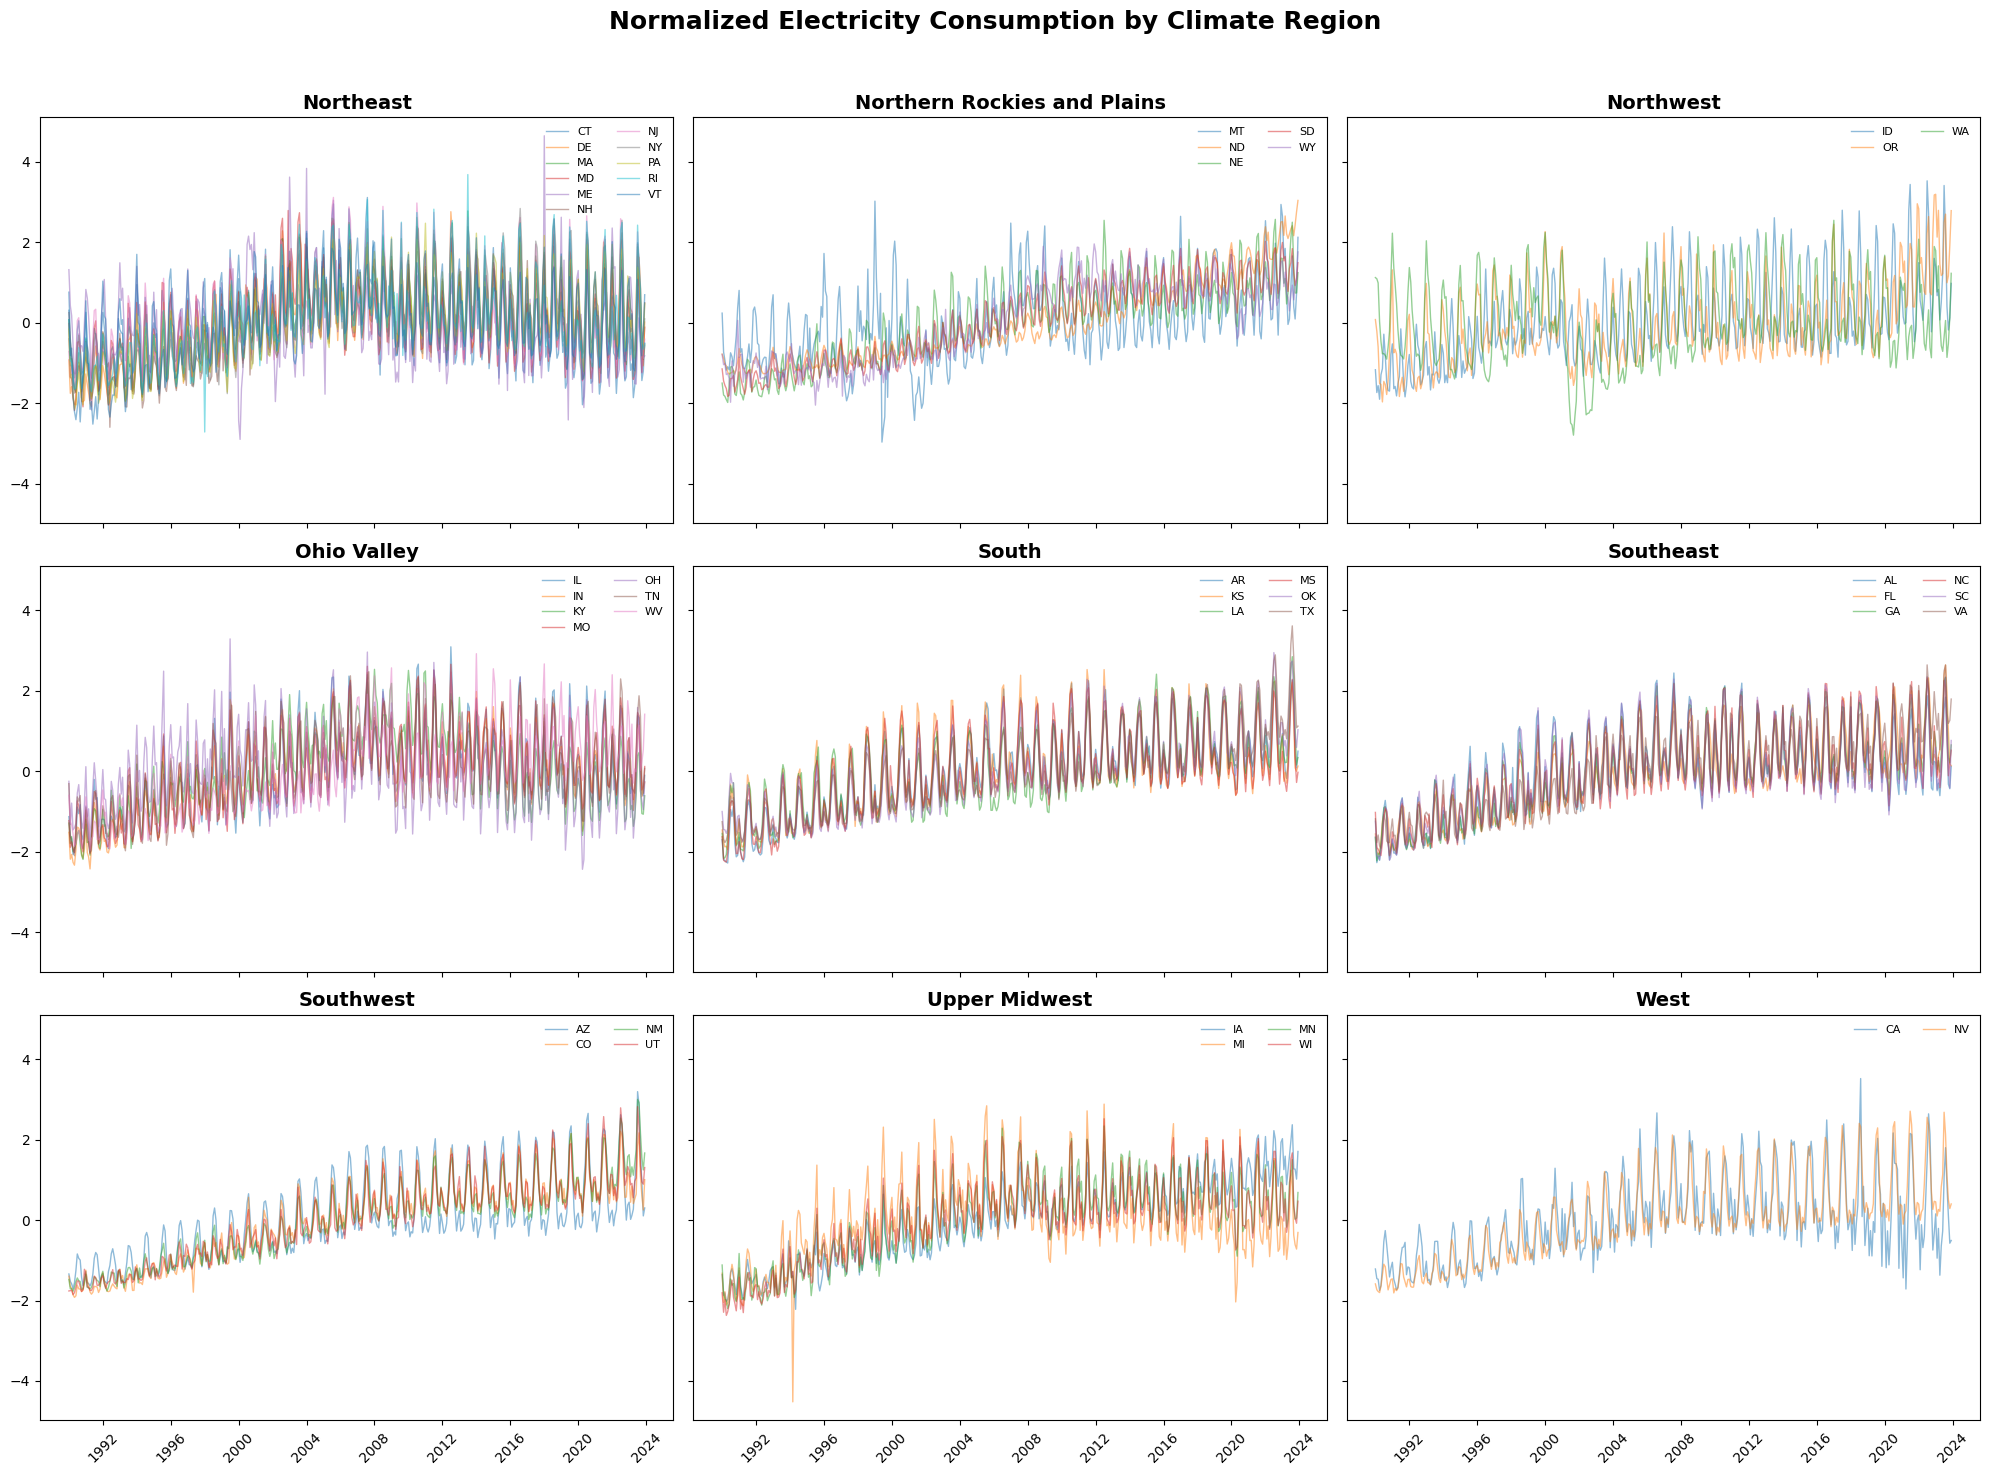

In [29]:
# climate region label별 사각화

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# state별 데이터 정규화: state별 소비량 크기 차이 해소 후 패턴만 비교
df_state_norm = pd.DataFrame(
    StandardScaler().fit_transform(df_state),
    index=df_state.index,
    columns=df_state.columns
)

regions = np.unique(y)

fig, axes = plt.subplots(3, 3, figsize=(20, 15), sharex=True, sharey=True)
axes = axes.ravel()

for i, region in enumerate(regions):
    region_states = [s for s, r in state_region.items() if r == region]
    
    # region 내 개별 state 곡선
    for st in region_states:
        axes[i].plot(df_state_norm.index, df_state_norm[st], label=st, alpha=0.5, linewidth=1)
      
    axes[i].set_title(region, fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(fontsize=8, loc='upper right', ncol=2, frameon=False)

plt.suptitle("Normalized Electricity Consumption by Climate Region", 
             fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("Normalized Electricity Consumption by Climate Region.png", dpi=300, bbox_inches="tight")
plt.show()

# 분석의 의미

단순히 MO 지역은 Ohio Valley 라고 예측했고, 실제로 Ohio Valley 였다 > 모델의 성능은 좋네요, 그런데 이게 무슨 의미가 있죠?

>>

Ohio Valley 로 묶인 주들은 전력 소비 시계열 패턴이 서로 유사하고, 다른 climate region과는 다른 시계열 패턴을 갖는다.
따라서, DTW Distance를 기반으로한 시계열 데이터 분류는 단순한 라벨링이 아니라 실제 데이터 패턴을 잘 반영하고 있음을 의미한다. 

이를 통해 유사한 소비 패턴을 가진 지역은 같은 방식의 전력 수요 예측 모델 혹은 같은 전력 공급 전략을 쓸 수 있다. 
ex) Ohio Valley climate region의 한 지역에서 모델을 개발하였고 성공적이었다면, 기타 Ohio Valley region에 해당 모델을 도입했을 때 성공적일 확률이 크다. 

또한, 특정 Climate Region이 폭염, 한파 혹은 토네이도와 같은 자연 재난으로 전력 수요가 급증할 경우, 해당 region의 다른 주들도 위험할 가능성이 있음을 데이터로서 설명 가능.

즉, '비슷한 기후니까 당연히 비슷하겠죠' 를 실제 데이터로서 설명할 수 있음

---

전략적으로 쓰일 수 있는 데이터긴 하겠네요. 그런데 그냥 해당 state의 electricity consumption만 분석하는게 더 최적화된 정책 설계가 가능하지 않나요? 굳이 climate region이라는 라벨링을 왜 해야하는건지?

>>

물론 단일 주의 데이터를 써도 단기적인 예측은 가능하다. 그러나 개별 주 데이터는 일시적 이벤트에 휘둘리기 쉬워 잡음이 많은 편이다. 

전기 에너지는 특성상 저장하기 어렵고 공급을 갑자기 늘리기도 어려운 자원이기 때문에, 이러한 잡음은 예측 오차 및 공급 불안정으로 이어질 우려가 있다. 

Climate region을 활용하면 구조적이고 장기적인 energy consumption 패턴을 반영할 수 있기 때문에 더욱 안정적이고 전략적인 전력 생산 계획 수립이 가능할 것.

물론 이 때 개별 state의 energy consumption date를 보충한다면 더욱 최적화된 설계가 가능할 것으로 전망.